In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import math as math
from scipy.stats import boxcox
from random import randrange
from random import seed
from random import random
from random import gauss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Multiply, Concatenate, Dropout
from pyod.models.knn import KNN 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.ensemble import RandomForestRegressor

In [2]:
data=pd.read_csv("synthetic_weather_data_wo_label_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)
data_labeled=pd.read_csv("synthetic_weather_data_wi_label_supervised_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)

In [3]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096   # 3 year
train= data.iloc[:-Ntest].copy()
test= data.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = data.index <=train.index[-1]
test_idx = data.index > train.index[-1]

data.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
data.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

data.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
data.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

data.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
data.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

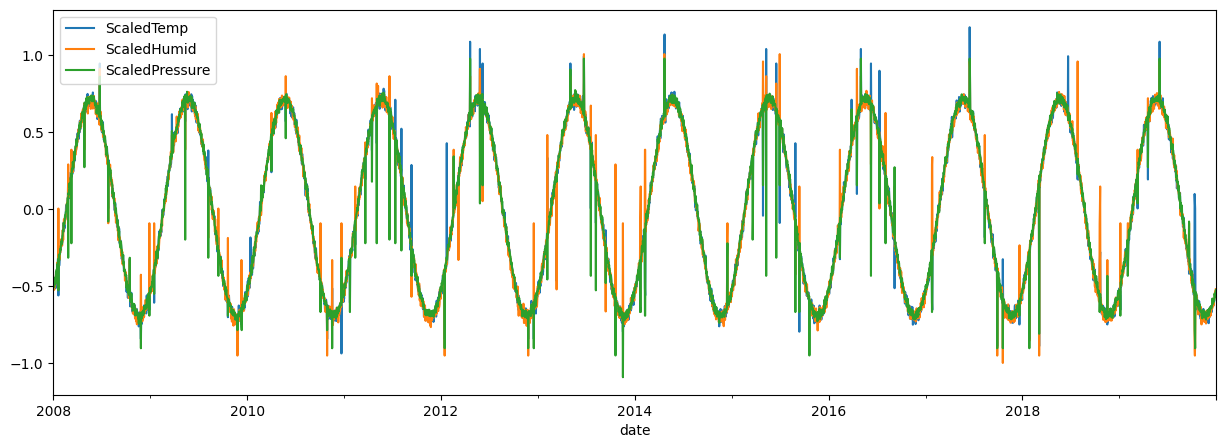

In [4]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

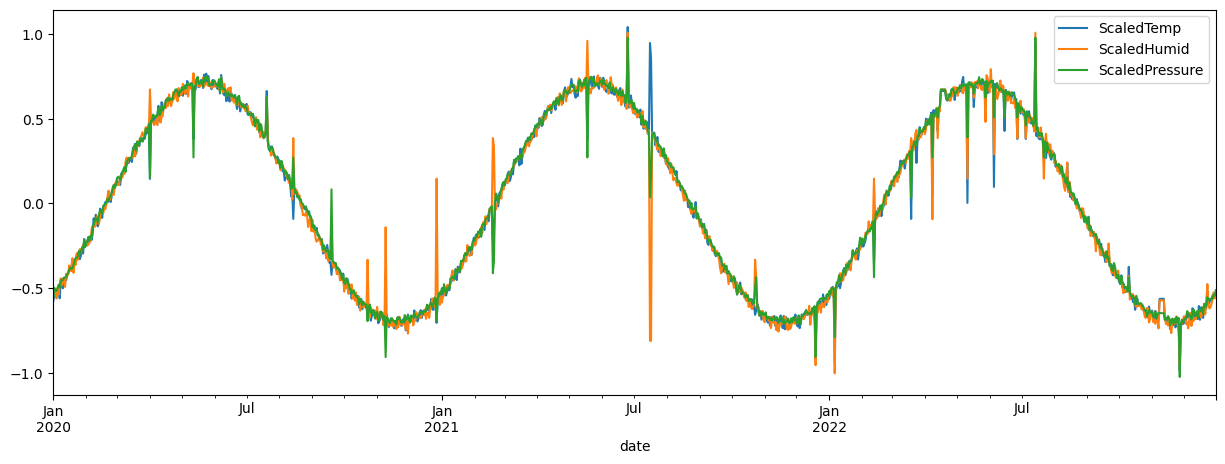

In [5]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

### Anomaly Detection on RAW Data

In [6]:
classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(train[cols], y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(test[cols]) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(test[cols])[:,1]

### ML + AD

In [7]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

In [8]:
for i in range(1, 8):
    df_combined[f'ST_t-{i}'] = df_combined['ScaledTemp'].shift(i)

In [9]:
for i in range(1, 8):
    df_combined[f'SH_t-{i}'] = df_combined['ScaledHumid'].shift(i)

In [10]:
for i in range(1, 8):
    df_combined[f'SP_t-{i}'] = df_combined['ScaledPressure'].shift(i)

In [11]:
df_combined = df_combined.dropna()

In [12]:
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_data = df_combined.iloc[:-nest_samples].copy()
test_data = df_combined.iloc[-nest_samples:].copy()

In [13]:
features = [col for col in df_combined.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]
X_train, y_train = train_data[features], train_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [14]:
x_test, y_test = test_data[features], test_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [15]:
rf = RandomForestRegressor()
#n_estimators=100, random_state=42

models = []
for i in range(3):
    model = rf
    model.fit(X_train, y_train.iloc[:, i])
    models.append(model)
    
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models[i].predict(X_train))
    
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models[i].predict(x_test))

In [16]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

In [17]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

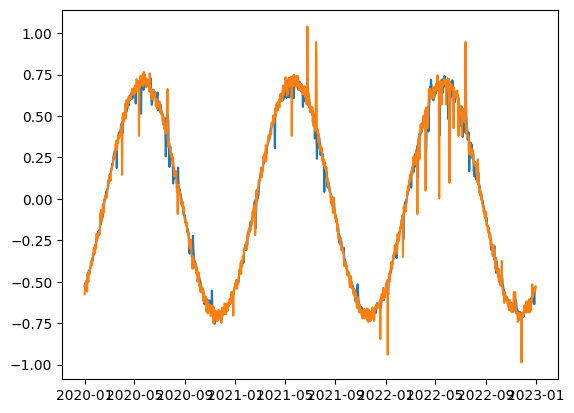

In [18]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])
#plt.plot(df_prediction_train['Predicted_temperature'])

In [19]:
#test_data(Predicted+actual)
data_temp_mladtest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp']})
data_humidity_mladtest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid']})
data_pressure_mladtest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure']})
data_kNN_mladtest=pd.concat([data_temp_mladtest,data_humidity_mladtest,data_pressure_mladtest],axis=1)

In [20]:
nest_samples=1096
le = LabelEncoder()

ground_truth = data_labeled.iloc[:, -1].values
ground_truth_train = ground_truth[:-nest_samples].copy()
ground_truth_test = ground_truth[-nest_samples:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

In [21]:
classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn_mlad = KNN()

# Prediction on training data
model_knn_mlad.fit(data_kNN_mladtest, y=None)  # y is ignored in unsupervised setting.
train_prediction_mlad = model_knn_mlad.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_mlad_scores = model_knn_mlad.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_mlad = model_knn_mlad.predict(data_kNN_mladtest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_mlad_scores = model_knn_mlad.predict_proba(data_kNN_mladtest)[:,1]

In [22]:
df_combined.shape

(5472, 24)

### HM + AD

### Physical Modeling with VAR when 3 year test set and 50 lag

In [23]:
lag_order = 50

In [24]:
"""temp_pred= 0.15*temp(t-1)+0.04*temp(t-2)+0.03*humid(t-2)+0.03*humid(t-5)+0.05*temp(t-6)+0.03*humid(t-9)+0.03*temp(t-10)
              +0.03*humid(t-12)+0.05*pressure(t-13)+0.03*humid(t-15)+0.03*pressure(t-15)+0.03*pressure(t-18)+0.03*humid(t-21)
              -0.03*pressure(t-32)+0.05*temp(t-37)-0.03*pressure(t-38)-0.05*temp(t-49)-0.03*temp(t-50)-0.03*pressure(t-50)"""

'temp_pred= 0.15*temp(t-1)+0.04*temp(t-2)+0.03*humid(t-2)+0.03*humid(t-5)+0.05*temp(t-6)+0.03*humid(t-9)+0.03*temp(t-10)\n              +0.03*humid(t-12)+0.05*pressure(t-13)+0.03*humid(t-15)+0.03*pressure(t-15)+0.03*pressure(t-18)+0.03*humid(t-21)\n              -0.03*pressure(t-32)+0.05*temp(t-37)-0.03*pressure(t-38)-0.05*temp(t-49)-0.03*temp(t-50)-0.03*pressure(t-50)'

In [25]:
"""humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)
            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)"""

'humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)\n            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)'

In [26]:
"""pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)
                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)
                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)"""

'pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)\n                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)\n                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)'

In [27]:
df_laggedtemp=pd.DataFrame()
df_laggedtemp['temp_L1']=df_combined['ScaledTemp'].shift(1)
df_laggedtemp['temp_L2']=df_combined['ScaledTemp'].shift(2)
df_laggedtemp['humid_L2']=df_combined['ScaledHumid'].shift(2)
df_laggedtemp['humid_L5']=df_combined['ScaledHumid'].shift(5)
df_laggedtemp['temp_L6']=df_combined['ScaledTemp'].shift(6)
df_laggedtemp['humid_L9']=df_combined['ScaledHumid'].shift(9)
df_laggedtemp['temp_L10']=df_combined['ScaledTemp'].shift(10)
df_laggedtemp['humid_L12']=df_combined['ScaledHumid'].shift(12)
df_laggedtemp['pressure_L13']=df_combined['ScaledPressure'].shift(13)
df_laggedtemp['humid_L15']=df_combined['ScaledHumid'].shift(15)
df_laggedtemp['pressure_L15']=df_combined['ScaledPressure'].shift(15)
df_laggedtemp['pressure_L18']=df_combined['ScaledPressure'].shift(18)
df_laggedtemp['humid_L21']=df_combined['ScaledHumid'].shift(21)
df_laggedtemp['pressure_L32']=df_combined['ScaledPressure'].shift(32)
df_laggedtemp['temp_L37']=df_combined['ScaledTemp'].shift(37)
df_laggedtemp['pressure_L38']=df_combined['ScaledPressure'].shift(38)
df_laggedtemp['temp_L49']=df_combined['ScaledTemp'].shift(49)
df_laggedtemp['temp_L50']=df_combined['ScaledTemp'].shift(50)
df_laggedtemp['pressure_L50']=df_combined['ScaledPressure'].shift(50)

In [28]:
df_vartemp=[df_laggedtemp['temp_L1'],df_laggedtemp['temp_L2'],df_laggedtemp['humid_L2'],df_laggedtemp['humid_L5'],
            df_laggedtemp['temp_L6'],df_laggedtemp['humid_L9'],df_laggedtemp['temp_L10'],
            df_laggedtemp['humid_L12'],df_laggedtemp['pressure_L13'],
            df_laggedtemp['humid_L15'],df_laggedtemp['pressure_L15'],
            df_laggedtemp['pressure_L18'],df_laggedtemp['humid_L21'],
            df_laggedtemp['pressure_L32'],df_laggedtemp['temp_L37'],
            df_laggedtemp['pressure_L38'],df_laggedtemp['temp_L49'],
            df_laggedtemp['temp_L50'],df_laggedtemp['pressure_L50']]
df_vartemp=pd.concat(df_vartemp,axis=1)

### Humidity prediction from VAR Model

In [29]:
"""humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)
            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)"""

'humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)\n            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)'

In [30]:
df_laggedhumid=pd.DataFrame()
df_laggedhumid['humid_L1']=df_combined['ScaledHumid'].shift(1)
df_laggedhumid['pressure_L3']=df_combined['ScaledPressure'].shift(3)
df_laggedhumid['pressure_L10']=df_combined['ScaledPressure'].shift(10)
df_laggedhumid['humid_L11']=df_combined['ScaledHumid'].shift(11)
df_laggedhumid['temp_L28']=df_combined['ScaledTemp'].shift(28)
df_laggedhumid['humid_L28']=df_combined['ScaledHumid'].shift(28)
df_laggedhumid['temp_L32']=df_combined['ScaledTemp'].shift(32)
df_laggedhumid['pressure_L37']=df_combined['ScaledPressure'].shift(37)
df_laggedhumid['humid_L47']=df_combined['ScaledHumid'].shift(47)
df_laggedhumid['pressure_L48']=df_combined['ScaledPressure'].shift(48)

In [31]:
df_varhumid=[df_laggedhumid['humid_L1'],df_laggedhumid['pressure_L3'],df_laggedhumid['pressure_L10'],
             df_laggedhumid['humid_L11'],df_laggedhumid['temp_L28'],df_laggedhumid['humid_L28'],df_laggedhumid['temp_L32'],
             df_laggedhumid['pressure_L37'],df_laggedhumid['humid_L47'],
             df_laggedhumid['pressure_L48']]
df_varhumid=pd.concat(df_varhumid,axis=1)

### Pressure prediction from VAR Model

In [32]:
"""pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)
                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)
                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)"""

'pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)\n                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)\n                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)'

In [33]:
df_laggedpressure=pd.DataFrame()
df_laggedpressure['pressure_L1']=df_combined['ScaledPressure'].shift(1)
df_laggedpressure['temp_L12']=df_combined['ScaledTemp'].shift(12)
df_laggedpressure['pressure_L12']=df_combined['ScaledPressure'].shift(12)
df_laggedpressure['temp_L19']=df_combined['ScaledTemp'].shift(19)
df_laggedpressure['temp_L38']=df_combined['ScaledTemp'].shift(38)
df_laggedpressure['humid_L38']=df_combined['ScaledHumid'].shift(38)
df_laggedpressure['humid_L50']=df_combined['ScaledHumid'].shift(50)

In [34]:
df_varpressure=[df_laggedpressure['pressure_L1'],
                        df_laggedpressure['temp_L12'],
                        df_laggedpressure['pressure_L12'],
                        df_laggedpressure['temp_L19'],
                        df_laggedpressure['temp_L38'],df_laggedpressure['humid_L38'],
                        df_laggedpressure['humid_L50']]
df_varpressure=pd.concat(df_varpressure,axis=1)

In [35]:
df_combined.head()

,ScaledTemp,ScaledHumid,ScaledPressure,ST_t-1,ST_t-2,ST_t-3,ST_t-4,ST_t-5,ST_t-6,ST_t-7,...,SH_t-5,SH_t-6,SH_t-7,SP_t-1,SP_t-2,SP_t-3,SP_t-4,SP_t-5,SP_t-6,SP_t-7
date,,,,,,,,,,,,,,,,,,,,,
2008-01-08,-0.462989,-0.493544,-0.446668,-0.506365,-0.502593,-0.487977,-0.500236,-0.498821,-0.513437,-0.472419,...,-0.516978,-0.515065,-0.518412,-0.483165,-0.491641,-0.478455,-0.506711,-0.486226,-0.504121,-0.500118
2008-01-09,-0.515794,-0.460545,-0.486461,-0.462989,-0.506365,-0.502593,-0.487977,-0.500236,-0.498821,-0.513437,...,-0.526064,-0.516978,-0.515065,-0.446668,-0.483165,-0.491641,-0.478455,-0.506711,-0.486226,-0.504121
2008-01-10,-0.441773,-0.455285,-0.443607,-0.515794,-0.462989,-0.506365,-0.502593,-0.487977,-0.500236,-0.498821,...,-0.508847,-0.526064,-0.516978,-0.486461,-0.446668,-0.483165,-0.491641,-0.478455,-0.506711,-0.486226
2008-01-11,-0.437529,-0.427068,-0.408524,-0.441773,-0.515794,-0.462989,-0.506365,-0.502593,-0.487977,-0.500236,...,-0.485892,-0.508847,-0.526064,-0.443607,-0.486461,-0.446668,-0.483165,-0.491641,-0.478455,-0.506711
2008-01-12,-0.454503,-0.454806,-0.461502,-0.437529,-0.441773,-0.515794,-0.462989,-0.506365,-0.502593,-0.487977,...,-0.504543,-0.485892,-0.508847,-0.408524,-0.443607,-0.486461,-0.446668,-0.483165,-0.491641,-0.478455


In [36]:
df=[df_vartemp,df_varhumid,df_varpressure,df_combined['ScaledTemp'],df_combined['ScaledHumid'],df_combined['ScaledPressure']]
df=pd.concat(df, axis=1)

In [37]:
df.dropna(inplace=True)

In [38]:
df.shape

(5422, 39)

In [39]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_data_hm = df.iloc[:-nest_samples].copy()
test_data_hm = df.iloc[-nest_samples:].copy()

In [40]:
features = [col for col in df.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]
X_train_hm, y_train_hm = train_data_hm[features], train_data_hm[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [41]:
x_test_hm, y_test_hm = test_data_hm[features], test_data_hm[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [42]:
input_tensor = Input(shape=(36,))
hidden1 = Dense(64, activation='relu')(input_tensor)
hidden1_reg = Dropout(0.1)(hidden1)
hidden2 = Dense(96, activation='relu')(hidden1_reg)
hidden2_reg = Dropout(0.1)(hidden2)
hidden3 = Dense(36, activation='relu')(hidden2_reg)
coeffs_temp = Dense(36)(hidden3)
coeffs_humid = Dense(36)(hidden3)
coeffs_pressure = Dense(36)(hidden3)
mul_temp = Multiply()([coeffs_temp, input_tensor])
mul_humidity = Multiply()([coeffs_humid, input_tensor])
mul_pressure = Multiply()([coeffs_pressure, input_tensor])
temp = tf.reduce_sum(mul_temp, axis= -1, keepdims=True)
humid = tf.reduce_sum(mul_humidity, axis= -1, keepdims=True)
pressure =tf.reduce_sum(mul_pressure, axis= -1, keepdims=True)
output=Concatenate(axis=1)([temp, humid, pressure])
model = Model(input_tensor, output)

In [43]:
#optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer='adam')

In [44]:
checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model_3yrTestdata_combined.h5',
    monitor='val_loss',
    save_best_only= True,
    save_weights_only= True,
    mode= 'min'
)

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.0001, mode ="min" ,restore_best_weights=True)
#history = model.fit(X_train_hm.values, y_train_hm.values, epochs=100, batch_size=16, verbose=1, validation_split=0.1, callbacks=[callback,checkpoint])

In [46]:
model.load_weights('best_model_3yrTestdata_combined.h5')

In [47]:
prediction_hm = model.predict(x_test_hm.values)

35/35 [==============================] - 0s 3ms/step


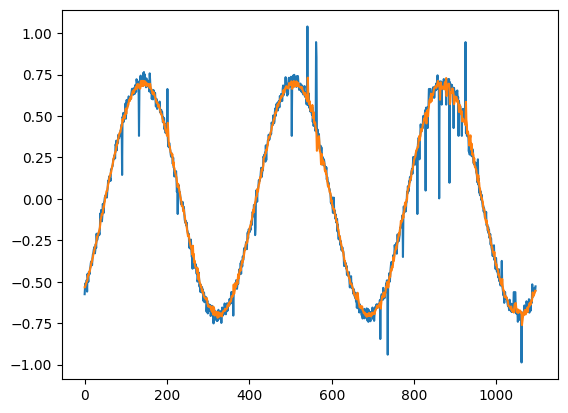

In [48]:
import matplotlib.pyplot as plt
plt.plot(y_test_hm.values[:,0])
plt.plot(prediction_hm[:,0])

In [49]:
Ntest=1096
le=LabelEncoder()

y = data_labeled.iloc[:, -1].values
ground_truth_train = y[:-Ntest].copy()
ground_truth_test = y[-Ntest:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

In [50]:
#test_data
data_temp_hmadtest = pd.DataFrame({'predicted_temp': prediction_hm[:,0], 'actual_temp': y_test_hm.values[:,0]})
data_humidity_hmadtest = pd.DataFrame({'predicted_humid': prediction_hm[:,1], 'actual_humid': y_test_hm.values[:,1]})
data_pressure_hmadtest = pd.DataFrame({'predicted_pressure': prediction_hm[:,2], 'actual_pressure': y_test_hm.values[:,2]})
data_kNN_hmadtest=pd.concat([data_temp_hmadtest,data_humidity_hmadtest,data_pressure_hmadtest],axis=1)

In [51]:
classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn_hmad = KNN()

# Prediction on training data
model_knn_hmad.fit(data_kNN_hmadtest, y=None)  # y is ignored in unsupervised setting.
train_prediction_hmad = model_knn_hmad.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_hmad_scores = model_knn_hmad.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_hmad = model_knn_hmad.predict(data_kNN_hmadtest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_hmad_scores = model_knn_hmad.predict_proba(data_kNN_hmadtest)[:,1]

### Evaluation

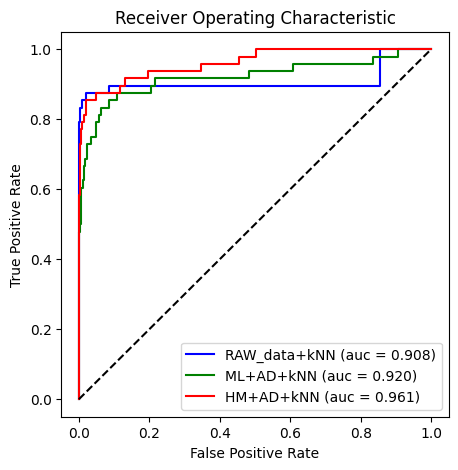

In [52]:
# Calculate AUC-ROC score
auc_roc_raw = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr_raw, tpr_raw, thresholds_raw = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN_raw = auc(fpr_raw,tpr_raw)

auc_roc_mlad = roc_auc_score(ground_truth_test, test_prediction_mlad_scores)
fpr_mlad, tpr_mlad, thresholds_mlad = roc_curve(ground_truth_test, test_prediction_mlad_scores)
auc_kNN_mlad = auc(fpr_mlad,tpr_mlad)

auc_roc_hmad = roc_auc_score(ground_truth_test, test_prediction_hmad_scores)
fpr_hmad, tpr_hmad, thresholds_hmad = roc_curve(ground_truth_test, test_prediction_hmad_scores)
auc_kNN_hmad = auc(fpr_hmad,tpr_hmad)


plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_raw, tpr_raw, linestyle='-', color='b', label='RAW_data+kNN (auc = %0.3f)' % auc_kNN_raw)

#plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_mlad, tpr_mlad, linestyle='-', color='g', label='ML+AD+kNN (auc = %0.3f)' % auc_kNN_mlad)

#plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_hmad, tpr_hmad, linestyle='-', color='r', label='HM+AD+kNN (auc = %0.3f)' % auc_kNN_hmad)


plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### Confusion Matrix 

In [53]:
#Raw data Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(test[cols]))

array([[976,  72],
       [  6,  42]], dtype=int64)

In [54]:
#ML+AD data Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn_mlad.predict(data_kNN_mladtest))

array([[991,  57],
       [ 10,  38]], dtype=int64)

In [55]:
#HM+AD data Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn_hmad.predict(data_kNN_hmadtest))

array([[997,  51],
       [  6,  42]], dtype=int64)

### RMS and MAE Score

In [56]:
#Raw
print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(test[cols]), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


On Test Data:
KNN ROC:0.9081, precision @ rank n:0.8333

Outlier prediction information on Test Data: 1096 {0: 982, 1: 114}
No of Errors in test set: 78

RMS on Test Set : 0.2667730931178758

MAE on Test Set : 0.07116788321167883


In [57]:
#MLAD
print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_mlad_scores)
unique, counts = np.unique(test_prediction_mlad, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_mladtest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction_mlad != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction_mlad, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction_mlad)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


On Test Data:
KNN ROC:0.92, precision @ rank n:0.6667

Outlier prediction information on Test Data: 1096 {0: 1001, 1: 95}
No of Errors in test set: 67

RMS on Test Set : 0.24724762255947755

MAE on Test Set : 0.06113138686131387


In [58]:
#HMAD
print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_hmad_scores)
unique, counts = np.unique(test_prediction_hmad, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_hmadtest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction_hmad != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction_hmad, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction_hmad)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


On Test Data:
KNN ROC:0.9605, precision @ rank n:0.7917

Outlier prediction information on Test Data: 1096 {0: 1003, 1: 93}
No of Errors in test set: 57

RMS on Test Set : 0.228051089166601

MAE on Test Set : 0.05200729927007299
